In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../")
DATA_PATH = '../data/'

## Data

In [31]:
k = 0.00005
sampled_data = pd.read_pickle(DATA_PATH + 'train_data.pkl').sample(frac=k, random_state=137)
# sample size

In [32]:
# scaling data
%load_ext autoreload
%autoreload 2

# split on train and test
from sklearn.model_selection import train_test_split
from data_pipeline import dropFalseMCParticles

unused_features = [
    'index', 'seed_nbIT', 'seed_nLayers', 'seed_mva_value',
    'is_downstream_reconstructible_not_electron', 'is_true_seed',
    'has_MCParticle_not_electron'
]
data = sampled_data.drop(unused_features, axis=1)
data = dropFalseMCParticles().fit_transform(data)
data = data.astype(np.float32)

data.info()

train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)
label_names = [
    'is_downstream_reconstructible'
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 1042314 to 2405649
Data columns (total 9 columns):
is_downstream_reconstructible    87 non-null float32
seed_chi2PerDoF                  87 non-null float32
seed_p                           87 non-null float32
seed_pt                          87 non-null float32
seed_nLHCbIDs                    87 non-null float32
seed_x                           87 non-null float32
seed_y                           87 non-null float32
seed_tx                          87 non-null float32
seed_ty                          87 non-null float32
dtypes: float32(9)
memory usage: 3.7 KB


### limited features tupled model

In [33]:
x_train = train_set.drop(label_names, axis=1)
y_train = train_set[label_names].copy().astype(np.int32)

x_test = test_set.drop(label_names, axis=1)
y_test = test_set[label_names].copy().astype(np.int32)



from data_pipeline import data_pipeline_basic as data_pipeline
pipeline = data_pipeline()
x_train = pipeline.fit_transform(x_train)
x_test = pipeline.transform(x_test)


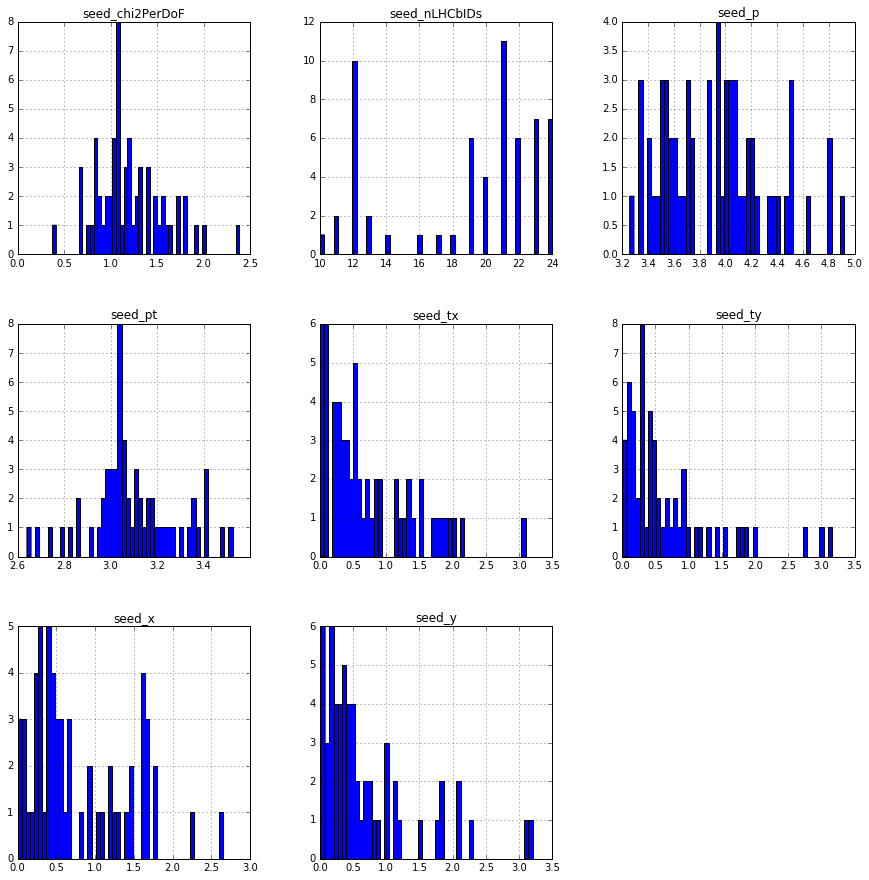

In [34]:
_ = x_train.hist(bins=50, figsize=(15,15))

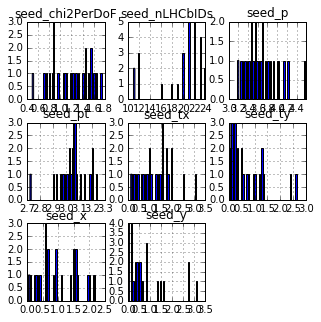

In [35]:
_ = x_test.hist(bins=50, figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efdc78f5780>]], dtype=object)

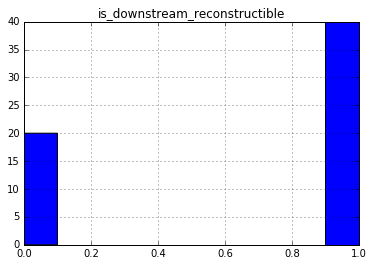

In [36]:
y_train.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efdc77ede10>]], dtype=object)

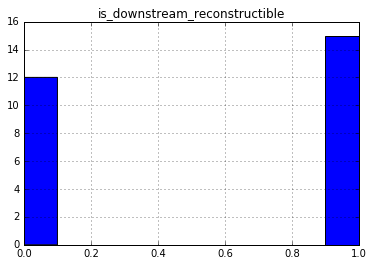

In [37]:
y_test.hist()

In [38]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train['is_downstream_reconstructible']), y_train['is_downstream_reconstructible'])

In [39]:
from keras.callbacks import TensorBoard
from models import KerasDNN
from models import LookupClassifier
import time

date_created = time.ctime()

DNNclf = KerasDNN(
    (x_train.shape[1],),
    (2,),
    neurons=100,
    layers=3,
#     dropout=0.05,
    loss_metric='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    last_layer_act='softmax'
)



In [40]:
DNNclf.fit(
    x_train.values, y_train.values,
    epochs=20,
    validation_data=(x_test.values, y_test.values)

)

Train on 60 samples, validate on 27 samples
Epoch 1/20
60/60 [==============================] - 0s - loss: 1.0874 - acc: 0.5667 - val_loss: 0.8279 - val_acc: 0.4444
Epoch 2/20
60/60 [==============================] - 0s - loss: 0.6572 - acc: 0.6500 - val_loss: 0.7788 - val_acc: 0.3704
Epoch 3/20
60/60 [==============================] - 0s - loss: 0.5047 - acc: 0.7667 - val_loss: 0.7294 - val_acc: 0.3704
Epoch 4/20
60/60 [==============================] - 0s - loss: 0.4595 - acc: 0.7667 - val_loss: 0.7067 - val_acc: 0.5185
Epoch 5/20
60/60 [==============================] - 0s - loss: 0.4145 - acc: 0.8167 - val_loss: 0.7022 - val_acc: 0.5556
Epoch 6/20
60/60 [==============================] - 0s - loss: 0.3336 - acc: 0.8333 - val_loss: 0.7050 - val_acc: 0.4815
Epoch 7/20
60/60 [==============================] - 0s - loss: 0.3004 - acc: 0.9167 - val_loss: 0.7193 - val_acc: 0.4444
Epoch 8/20
60/60 [==============================] - 0s - loss: 0.2428 - acc: 0.9167 - val_loss: 0.7378 - val_

In [50]:
import keras

In [51]:
input_variables = []
for column in x_train.columns:
    input_variables.append(keras.layers.Input(shape=(1,), name='_'.join([column, 'input']),))
    
concatenated_input = keras.layers.Concatenate()(input_variables)

In [53]:
new_model_output = DNNclf.model(concatenated_input)

In [57]:
new_model = keras.models.Model(inputs=input_variables, output=new_model_output)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`
  if __name__ == '__main__':


In [59]:
new_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
seed_chi2PerDoF_input (InputLaye (None, 1)             0                                            
____________________________________________________________________________________________________
seed_p_input (InputLayer)        (None, 1)             0                                            
____________________________________________________________________________________________________
seed_pt_input (InputLayer)       (None, 1)             0                                            
____________________________________________________________________________________________________
seed_nLHCbIDs_input (InputLayer) (None, 1)             0                                            
___________________________________________________________________________________________

In [61]:
from pprint import pprint

In [77]:
model_arch = DNNclf.model.to_json()

In [66]:
import time
date_created = time.ctime() 

In [73]:
import os
model_path = '../saved_models/lwtnn/' + date_created + '/'
os.mkdir(model_path)

In [78]:
with open(model_path + 'architecture.json', 'w') as arch_file:
    arch_file.write(model_arch)

In [79]:
DNNclf.model.save_weights(model_path + 'weights.h5')

In [41]:
from sklearn.metrics import accuracy_score

In [44]:
%time accuracy_score(y_test.values, DNNclf.predict(x_test.values))

CPU times: user 216 ms, sys: 0 ns, total: 216 ms
Wall time: 215 ms


0.25925925925925924

In [46]:
from sklearn.metrics import roc_auc_score

In [48]:
roc_auc_score(y_test.values, DNNclf.predict_proba(x_test.values)[:,1] )

0.28888888888888886

In [20]:
pipeline.named_steps

{'chi2sqrt': chi2sqrt(),
 'plog': plog(),
 'ptlog': ptlog(),
 'tx_abs': txScale_abs(),
 'ty_abs': tyScale_abs(),
 'x_abs': xScale_abs(),
 'y_abs': yScale_abs()}

In [49]:
for name, step in pipeline.named_steps.items():
    print(step)
    try:
        print(step.scaler.scale_)
        print('std: ', step.scaler.scale_)
        print('mean: ', step.scaler.mean_)
    except Exception as e:
            pass

yScale_abs()
[ 494.10678101]
std:  [ 494.10678101]
mean:  [ 57.4411087]
ptlog()
plog()
txScale_abs()
[ 0.25948808]
std:  [ 0.25948808]
mean:  [-0.03209869]
xScale_abs()
[ 655.93023682]
std:  [ 655.93023682]
mean:  [-75.53407288]
chi2sqrt()
tyScale_abs()
[ 0.06843147]
std:  [ 0.06843147]
mean:  [ 0.00718875]


In [22]:
import gc
gc.collect()

452